In [41]:
import os
from tqdm import tqdm
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import rc_params
from skimage.feature import daisy
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc
%matplotlib inline

# load the labels using pandas
labels = pd.read_csv("data/train_labels.csv",index_col=0)

from image_prep import create_feature_matrix

In [32]:
bees_features = np.load("bees_features3.npy")

In [33]:
ss = StandardScaler()
bees_stand = ss.fit_transform(bees_features)
bees_stand.shape

(3969, 168046)

### PCA Analysis

In [18]:
pca = PCA(n_components=4000)
bees_pca = pca.fit_transform(bees_stand)

In [34]:
#np.save("bees_pca_regular.npy", bees_pca)
bbes_pca = np.load("bees_pca_regular.npy")

### SVC Analysis

In [35]:
X_train, X_test, y_train, y_test = train_test_split(bees_pca,labels.genus.values,test_size=.2,random_state=1234)

In [36]:
#svc = svm.SVC(C = 1, kernel = 'poly', degree = 5, class_weight='auto', probability=True)

#svc.fit(X_train, y_train)

In [37]:
tuned_parameters = {'kernel': ['poly'], 'degree': [5],'C': [1]}

svc = svm.SVC()

gs = GridSearchCV(svm.SVC(class_weight='auto', probability=True),param_grid=tuned_parameters, cv = 3, verbose= 2)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] kernel=poly, C=1, degree=5 ......................................
[CV] ............................. kernel=poly, C=1, degree=5 - 2.0min
[CV] kernel=poly, C=1, degree=5 ......................................
[CV] ............................. kernel=poly, C=1, degree=5 - 1.8min
[CV] kernel=poly, C=1, degree=5 ......................................
[CV] ............................. kernel=poly, C=1, degree=5 - 1.8min

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=True,
  random_state=None, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ['poly'], 'C': [1], 'degree': [5]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=2)

In [38]:
preds = gs.best_estimator_.predict_proba(X_test)

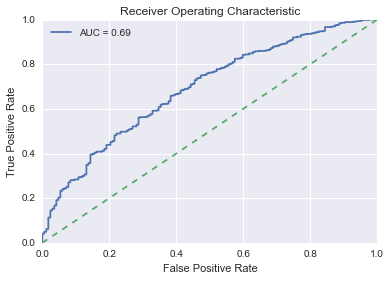

In [39]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,
                                                                preds[:, 1],
                                                                pos_label=1)

roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,
         true_positive_rate,
         label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
sf = pd.read_csv("data/SubmissionFormat.csv", index_col=0)

def make_predictions(submission_format_df,output_filepath="my_submission.csv"):
    prediction_df = submission_format_df.copy()
    
    # create features
    test_features = create_feature_matrix(submission_format_df)
    test_features_stand = ss.transform(test_features)   
    test_features_pca = pca.transform(test_features_stand)
    
    # predict with the best estimator from the grid search
    preds = gs.best_estimator_.predict_proba(test_features_pca)
    
    # copy the predictions to the dataframe with the ids and
    # write it out to a file
    prediction_df.genus = preds[:, 1]
    prediction_df.to_csv(output_filepath)
    
    return prediction_df
    
pred_df = make_predictions(sf, output_filepath="raw_hog_daisy_rbf.csv")
pred_df.head()

ValueError: operands could not be broadcast together with shapes (992,168046) (168742,) 

In [52]:
print "Best parameters:", gs.best_params_
print "Best score:", gs.best_score_

Best parameters: {'kernel': 'poly', 'C': 1, 'degree': 5}
Best score: 0.794330708661


In [51]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]},
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                  {'kernel': ['poly'], 'degree': [2, 3, 4 , 5],
                    'C': [1, 10, 100, 1000]}]

svc = svm.SVC()

gs = GridSearchCV(svm.SVC(class_weight='auto', probability=True),param_grid=tuned_parameters, cv = 3, verbose= 2)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ........................... kernel=rbf, C=1, gamma=0.001 - 1.8min
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ........................... kernel=rbf, C=1, gamma=0.001 - 1.8min
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ........................... kernel=rbf, C=1, gamma=0.001 - 1.7min
[CV] kernel=rbf, C=1, gamma=0.0001 ...................................
[CV] .......................... kernel=rbf, C=1, gamma=0.0001 - 1.8min
[CV] kernel=rbf, C=1, gamma=0.0001 ...................................
[CV] .......................... kernel=rbf, C=1, gamma=0.0001 - 1.8min
[CV] kernel=rbf, C=1, gamma=0.0001 ...................................
[CV] .......................... kernel=rbf, C=1, gamma=0.0001 - 1.8min
[CV] kernel=rbf, C=10, gamma=0.001 ...................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed: 85.6min



[CV] kernel=poly, C=1, degree=3 ......................................
[CV] ............................. kernel=poly, C=1, degree=3 - 1.7min
[CV] kernel=poly, C=1, degree=4 ......................................
[CV] ............................. kernel=poly, C=1, degree=4 - 1.7min
[CV] kernel=poly, C=1, degree=4 ......................................
[CV] ............................. kernel=poly, C=1, degree=4 - 1.8min
[CV] kernel=poly, C=1, degree=4 ......................................
[CV] ............................. kernel=poly, C=1, degree=4 - 1.7min
[CV] kernel=poly, C=1, degree=5 ......................................
[CV] ............................. kernel=poly, C=1, degree=5 - 1.8min
[CV] kernel=poly, C=1, degree=5 ......................................
[CV] ............................. kernel=poly, C=1, degree=5 - 1.8min
[CV] kernel=poly, C=1, degree=5 ......................................
[CV] ............................. kernel=poly, C=1, degree=5 - 1.8min
[CV] 

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 162.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=True,
  random_state=None, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=2)

In [60]:
gs.get_params()

{'cv': 3,
 'error_score': 'raise',
 'estimator': SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
   gamma=0.0, kernel='rbf', max_iter=-1, probability=True,
   random_state=None, shrinking=True, tol=0.001, verbose=False),
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__class_weight': 'auto',
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__gamma': 0.0,
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': True,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'fit_params': {},
 'iid': True,
 'loss_func': None,
 'n_jobs': 1,
 'param_grid': [{'C': [1, 10, 100, 1000],
   'gamma': [0.001, 0.0001],
   'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4, 5], 'kernel': ['poly']}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'score_func': None,
 'scoring': None,
 'verbose':

In [62]:
gs.score(X_test, y_test)

0.79471032745591941